# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scrnatools as rna
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import math
import phagepy
from phagepy import analysis

In [3]:
# Setup figure params
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Helvetica"
sc.set_figure_params(dpi=80, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
plt.rcParams['axes.unicode_minus'] = False
cmap = sns.color_palette("colorblind")

In [4]:
warnings.resetwarnings()

# Method definitions

In [66]:
def average_tech_reps(adata, sample_key, layer="X"):
    counts = rna.tl.get_expression_matrix(adata, gene_data=layer)
    counts[sample_key] = adata.obs[sample_key]
    counts = counts.groupby(sample_key).mean()
    avg_adata = sc.AnnData(counts)
    obs = pd.DataFrame(adata.obs.copy())
    obs.index = obs[sample_key]
    obs = obs.drop_duplicates(subset=sample_key)
    avg_adata.obs = avg_adata.obs.join(obs)
    return avg_adata

def calculate_FC(adata, control_key, control_values, layer="X", layer_added="FC"):
    control_data = rna.tl.get_expression_matrix(
        adata[adata.obs[control_key].isin(control_values)],
        gene_data=layer
    )
    if np.any(np.sum(control_data,axis=0)==0):
        raise ValueError('Zero expression peptides. Pseudocount +1 before running.')
    all_data = rna.tl.get_expression_matrix(adata, gene_data=layer)
    adata.layers[layer_added] = all_data/control_data.mean()
    
def calculate_Z(adata, control_key, control_values, layer="X", layer_added="Z_score"):
    control_data = rna.tl.get_expression_matrix(
        adata[adata.obs[control_key].isin(control_values)],
        gene_data=layer
    )
    if sum(control_data.sum(axis=0) == 0) > 0:
        print("Warning: some peptides have 0 variance in the control samples, some Z scores will be inf/NA")
    mean = control_data.mean(axis=0)
    std = control_data.std(axis=0) # Uses unbiased estimator of population variance by default (div by n-1 instead of n)
    all_data = rna.tl.get_expression_matrix(adata, gene_data=layer)
    adata.layers[layer_added] = (all_data-mean)/std
    
def get_peptide_stats(adata, FC_layer, Z_layer, FC_thresh, Z_thresh, obs_grouping_key, key_added="hits", stats_layer=None):
    FC_thresholded = rna.tl.get_expression_matrix(adata, gene_data=FC_layer) > FC_thresh
    Z_thresholded = rna.tl.get_expression_matrix(adata, gene_data=Z_layer) > Z_thresh
    hits = FC_thresholded & Z_thresholded
    
    hits[obs_grouping_key] = adata.obs[obs_grouping_key]
    hits = hits.groupby(obs_grouping_key).sum().T
    hits["gene"] = adata.var.gene
    hits["gene_isoform"] = adata.var.gene_isoform
    hits["sequence"] = adata.var.sequence
    
    if stats_layer is None:
        stats_layer = FC_layer
    LFC_background = rna.tl.get_expression_matrix(adata, gene_data=stats_layer)
    LFC_background[obs_grouping_key] = adata.obs[obs_grouping_key]
    group_min = LFC_background.groupby(obs_grouping_key).min().T
    hits = hits.join(group_min, rsuffix='_min')
    group_max = LFC_background.groupby(obs_grouping_key).max().T
    hits = hits.join(group_max, rsuffix='_max')
    group_med = LFC_background.groupby(obs_grouping_key).median().T
    hits = hits.join(group_med, rsuffix='_median')
    group_mean = LFC_background.groupby(obs_grouping_key).mean().T
    hits = hits.join(group_mean, rsuffix='_mean')
    
    adata.varm[key_added] = hits
    

def corr_plot(adata, layer="X", labels=None, cbar_args = [1, 0.25, 0.01, 0.5], save_path=None, *args, **kwargs):
    data = rna.tl.get_expression_matrix(adata, gene_data=layer)
    gene_corrs = pd.DataFrame(np.corrcoef(data), index=data.index, columns=data.index)
    if labels is not None:
        label_names = adata.obs.loc[gene_corrs.index, labels]
        gene_corrs.index = label_names
        gene_corrs.columns = label_names
    cg = sns.clustermap(
        gene_corrs,
        cmap="coolwarm",
        yticklabels=True,
        xticklabels=True,
        *args, **kwargs
    )

    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    cg.ax_heatmap.yaxis.tick_left()
    cg.ax_heatmap.set_ylabel("")
    cg.ax_heatmap.set_xlabel("")
    cg.ax_cbar.set_position(cbar_args)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    
def plot_FC_sum(adata, FC_layer, obs_group_key, obs_group_values=None, save_path=None, *args, **kwargs):
    FC_data = rna.tl.get_expression_matrix(adata, gene_data=FC_layer)
    FC_data[FC_data < 0] = 0
    FC_data = pd.DataFrame(FC_data.sum(axis=1))
    FC_data[obs_group_key] = averaged_adata.obs[obs_group_key]
    
    if obs_group_values is not None:
        FC_data = FC_data[FC_data[obs_group_key].isin(obs_group_values)]
        
    plt.figure(figsize=(3,4))
    sns.boxplot(
        FC_data,
        x=obs_group_key,
        y=0,
        *args, **kwargs
    )
    plt.xticks(rotation=90)
    plt.ylabel("sum(LFC over background)")
    plt.xlabel("")
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

def gene_level_box_plot(adata, obs_key, layer, gene, isoform_subset = None, figsize=None, save_path=None, threshold=None, *args, **kwargs):
    #get peptide counts for WT and KO groups for a gene
    adata_gene = adata[:,adata.var.gene == gene]
    data = rna.tl.get_expression_matrix(adata_gene, gene_data=layer)
    if isoform_subset is not None:
        isoform_peptides = data.columns[data.columns.str.contains(isoform_subset)]
        data = data[isoform_peptides]
        data.columns = [i.split("seq")[1] for i in data.columns]
        x="variable"
    else:
        x="peptide"
    n_peptides = len(data.columns)
    data = data.melt()
    data[obs_key] = adata_gene.obs[obs_key].tolist()*n_peptides
    if figsize is None:
        figsize = n_peptides*0.5,5
    plt.figure(figsize = figsize)
    ax1 = sns.boxplot(
        data = data,
        x = x,
        y = "value",
        hue = obs_key,
        showfliers=False,
        *args, **kwargs
    )
    ax2 = sns.stripplot(
        data = data,
        x = x,
        y = "value",
        hue = obs_key,
        dodge=True,
        legend=False,
        linewidth = 1,
        s=3,
        *args, **kwargs
    )
    if threshold is not None:
        plt.axhline(y=threshold, c="black", linestyle="--")
    plt.xticks(rotation=90)
    plt.title(f"{gene}_{isoform_subset}")
    plt.xlabel("peptide")
    plt.ylabel(layer)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    
def peptide_level_box_plot(adata, obs_key, layer, peptide, figsize=(4,4), threshold=None, *args, **kwargs):
    adata_gene = adata[:,adata.var_names == peptide]
    data = rna.tl.get_expression_matrix(adata_gene, gene_data=layer)
    data.columns = [i.split("seq")[1] for i in data.columns]
    data = data.melt()
    data[obs_key] = adata_gene.obs[obs_key].tolist()
    plt.figure(figsize = figsize)
    ax1 = sns.boxplot(
        data = data,
        x = "variable",
        y = "value",
        hue = obs_key,
        showfliers=False,
        *args, **kwargs
    )
    ax2 = sns.stripplot(
        data = data,
        x = "variable",
        y = "value",
        hue = obs_key,
        dodge=True,
        legend=False,
        linewidth = 1,
        s=3,
        *args, **kwargs
    )
    if threshold is not None:
        plt.axhline(y=threshold, c="black", linestyle="--")
    plt.title(adata_gene.var["gene"][0])
    plt.xlabel(peptide)
    plt.ylabel(layer)
    plt.show()
    
def gene_LFC_sum_plot(
    adata, gene, LFC_layer, obs_grouping_key,
    isoform_subset=None,
    include_groups=None,
    figsize=(3,5),
    *args, **kwargs
):
    FC_data = rna.tl.get_expression_matrix(adata, LFC_layer).T
    if isoform_subset is not None:
        FC_data["gene"] = adata.var.gene_isoform
        gene = f"{gene}_{isoform_subset}"
    else:
        FC_data["gene"] = adata.var.gene
    FC_data = FC_data.groupby("gene").sum().T
    FC_data[obs_grouping_key] = adata.obs[obs_grouping_key]
    if include_groups is not None:
        FC_data = FC_data[FC_data[obs_grouping_key].isin(include_groups)]
    plt.figure(figsize=figsize)
    sns.boxplot(
        FC_data,
        x=obs_grouping_key,
        y=gene,
        *args, **kwargs
    )
    plt.title(gene)
    plt.xticks(rotation=90)
    plt.ylabel("sum(LFC over background)")
    plt.show()
    
def median_LFC_Z_score_plot(adata, Z_layer, LFC_layer, LFC_thresh, obs_grouping_key, obs_grouping_subset, hits, subset_nonzero=True, *args, **kwargs):
    LZ_score_data = rna.tl.get_expression_matrix(adata, gene_data=Z_layer)
    LZ_score_data[obs_grouping_key] = adata.obs[obs_grouping_key]
    LZ_score_data = LZ_score_data.groupby(obs_grouping_key).median().T
    LFC_data = rna.tl.get_expression_matrix(adata, gene_data=LFC_layer)
    LFC_data[obs_grouping_key] = adata.obs[obs_grouping_key]
    LFC_data = LFC_data.groupby(obs_grouping_key).median().T

    plot_data = pd.DataFrame({"LFC": LFC_data[obs_grouping_subset], "LZ": LZ_score_data[obs_grouping_subset]})
    plot_data["hit"] = [i in hits for i in plot_data.index]
    if subset_nonzero:
        plot_data = plot_data[plot_data.LFC > 0]
        plot_data = plot_data[plot_data.LZ > 0]
    sns.scatterplot(
        plot_data,
        x="LFC",
        y="LZ",
        hue="hit",
        linewidth=0,
        s=5
    )
    plt.axvline(x=np.log2(LFC_thresh), color="black")
    plt.show()
    
def LFC_heatmap(data, cell_width=30, cell_height=30, save_path=None, *args, **kwargs):
    figdpi = plt.rcParams['figure.dpi']
    totalWidth = plt.rcParams['figure.subplot.right'] - plt.rcParams['figure.subplot.left']
    totalHeight = plt.rcParams['figure.subplot.top'] - plt.rcParams['figure.subplot.bottom']
    nrows, ncols = data.shape
    figWidth = (ncols*cell_width/figdpi)/totalWidth
    figHeight = (nrows*cell_height/figdpi)/totalHeight
    
    cg = sns.clustermap(
        data,
        figsize=(figWidth, figHeight),
        *args, **kwargs
    )

    axWidth = (ncols*cell_width)/(figWidth*figdpi)
    axHeight = (nrows*cell_height)/(figHeight*figdpi)
    ax_heatmap_og_pos = cg.ax_heatmap.get_position()
    cg.ax_heatmap.set_position(
        [ax_heatmap_og_pos.x0, ax_heatmap_og_pos.y0, axWidth, axHeight]
    )
    cbar_x_pos = 0.85 + ax_heatmap_og_pos.x0
    cbar_y_pos = ax_heatmap_og_pos.y0
    cbar_width = 25/(figWidth*300)
    cbar_height = axHeight
    cbar_args = [cbar_x_pos, cbar_y_pos, cbar_width, cbar_height]
    cg.ax_cbar.set_position(cbar_args)
    cg.ax_cbar.grid(False)
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    cg.ax_heatmap.yaxis.tick_left()
    cg.ax_heatmap.set_ylabel("")
    cg.ax_heatmap.set_xlabel("")
    cg.ax_heatmap.grid(False)
    cg.ax_heatmap.tick_params(axis='y', labelrotation=0)
    cg.ax_heatmap.tick_params(axis='x', labelrotation=90)
    cg.ax_heatmap.tick_params(bottom=True, left=True)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

# Import data

In [6]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

In [7]:
peptide_data = pd.read_csv(f"{rawDataPath}Thymus/Fezf2_Phip_seq/Conditional_KO_run_1/rpk_peptide.csv", index_col=0)
metadata = pd.read_csv(f"{rawDataPath}Thymus/Fezf2_Phip_seq/Conditional_KO_run_1/metadata.csv", index_col=0)

## Cleanup metadata, make AnnData

In [8]:
metadata["REPLICATE"] = [i.split("_")[1] for i in metadata.SAMPLE]
metadata["SAMPLE_NAME"] = [i.split("_")[0] for i in metadata.SAMPLE]

In [9]:
peptide_data.columns = [i.rsplit("_", 3)[0] for i in peptide_data.columns]

In [10]:
adata=sc.AnnData(X=peptide_data.T, dtype=np.float32)
adata.raw = adata
adata.obs = adata.obs.join(metadata)
adata.obs.GENOTYPE.value_counts()

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


COPA         24
NODAIREKO    24
NODAIREWT    24
NFKB2HET     19
NODWT        13
AG           10
RagKO        10
Fezf2WT       8
Fezf2KO       5
GFAP          4
Name: GENOTYPE, dtype: int64

# Technical replicates

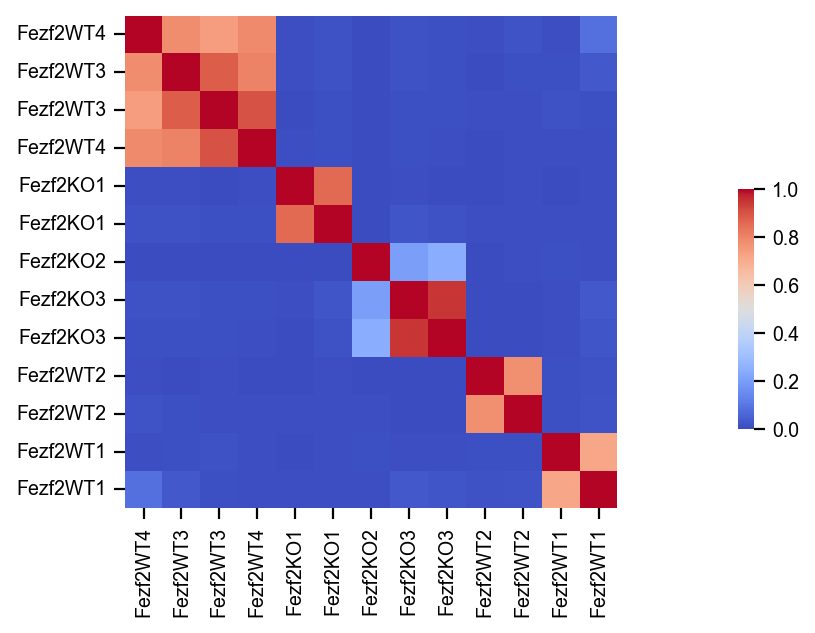

In [15]:
corr_plot(
    adata[adata.obs.GENOTYPE.isin(["Fezf2WT", "Fezf2KO"])],
    figsize=(5,5),
    layer="X",
    labels="SAMPLE_NAME",
    cbar_args=[0.95, 0.3, 0.02, 0.3],
    vmin=0,
    save_path="../analysis/B6_phip_seq/technical_replicate_coorelation.pdf"
)

In [16]:
#Take average counts of technical replicates
averaged_adata = average_tech_reps(
    adata = adata,
    sample_key = "SAMPLE_NAME"
)

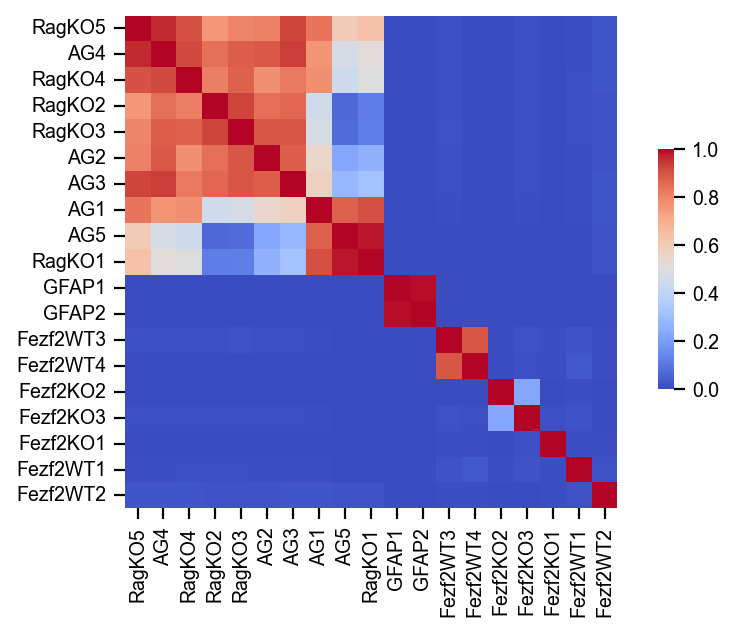

In [19]:
corr_plot(
    averaged_adata[averaged_adata.obs.GENOTYPE.isin(["Fezf2WT", "Fezf2KO", "AG", "RagKO", "GFAP"])],
    layer="X",
    figsize=(5,5),
    labels="SAMPLE_NAME",
    vmin=0,
    cbar_args=[0.85, 0.35, 0.02, 0.3],
    save_path="../analysis/B6_phip_seq/biological_replicate_coorelation.pdf"
)

## Add metadata columns to obs/var for analysis

In [20]:
#This file is publically available and can be accessed through https://www.protocols.io/workspaces/derisi-lab
new_annot = pd.read_csv(f"{rawDataPath}Thymus/Fezf2_Phip_seq/gene_annotations.csv", index_col=0)
averaged_adata.var["gene"] = new_annot.gene
averaged_adata.var["sequence"] = new_annot.sequence
averaged_adata.var["isoform"] = [f"isoform_{i.split('isoform')[1].split('_')[1]}" if "isoform" in i else "" for i in averaged_adata.var_names]
averaged_adata.var["gene_isoform"] = averaged_adata.var.gene + "_" + averaged_adata.var.isoform
averaged_adata.obs["neg_control"] = ["Background" if i in ["AG", "RagKO"] else i for i in averaged_adata.obs.GENOTYPE]

# Normalize to background

In [21]:
# Pseudocount data for LFC calculation
averaged_adata.layers["rpk+1"] = averaged_adata.X + 1

In [22]:
calculate_FC(
    averaged_adata,
    control_key='neg_control',
    control_values=["Background"],
    layer='rpk+1',
    layer_added="FC_background"
)
averaged_adata.layers["LFC_background"] = np.log2(averaged_adata.layers["FC_background"])

# Global autoanitbody load

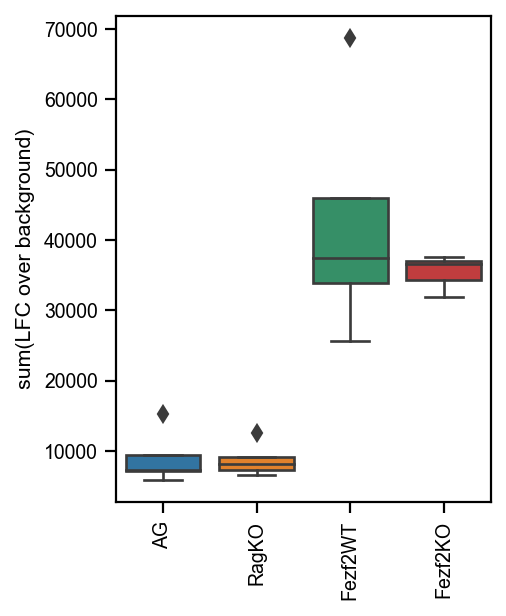

In [26]:
plot_FC_sum(
    averaged_adata,
    "LFC_background",
    "GENOTYPE",
    ["AG", "RagKO", "Fezf2WT", "Fezf2KO"],
    order=["AG", "RagKO", "Fezf2WT", "Fezf2KO"],
    save_path="../analysis/B6_phip_seq/global_autoantibody_load.pdf"
)

# Z score

In [27]:
calculate_Z(
    averaged_adata,
    control_key='neg_control',
    control_values=["Background"],
    layer='LFC_background',
    layer_added="Z_score_background"
)
averaged_adata.layers["LZ_score_background"] = np.log2(averaged_adata.layers["Z_score_background"])

/tmp/ipykernel_1642762/824801542.py:8: RuntimeWarning: invalid value encountered in log2
  averaged_adata.layers["LZ_score_background"] = np.log2(averaged_adata.layers["Z_score_background"])


# Get peptide hits

In [28]:
get_peptide_stats(
    averaged_adata,
    FC_layer = "LFC_background",
    FC_thresh = np.log2(3),
    Z_layer = "Z_score_background",
    Z_thresh = 3,
    obs_grouping_key="neg_control"
)

## KO

In [29]:
filtered_hits_KO = averaged_adata.varm['hits'].copy()
filtered_hits_KO = filtered_hits_KO[filtered_hits_KO["Fezf2KO_median"] >= np.log2(3)]
filtered_hits_KO = filtered_hits_KO[filtered_hits_KO["Fezf2WT_max"] < np.log2(3)]
filtered_hits_KO = filtered_hits_KO[filtered_hits_KO["Background_max"] < np.log2(3)]

In [30]:
filtered_hits_KO.shape[0]

118

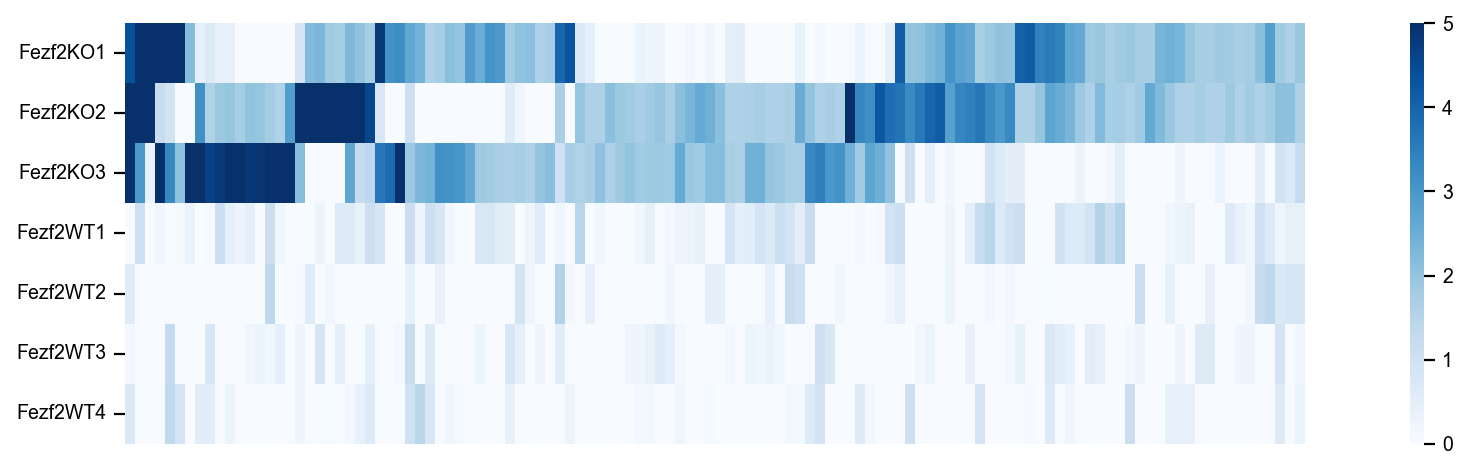

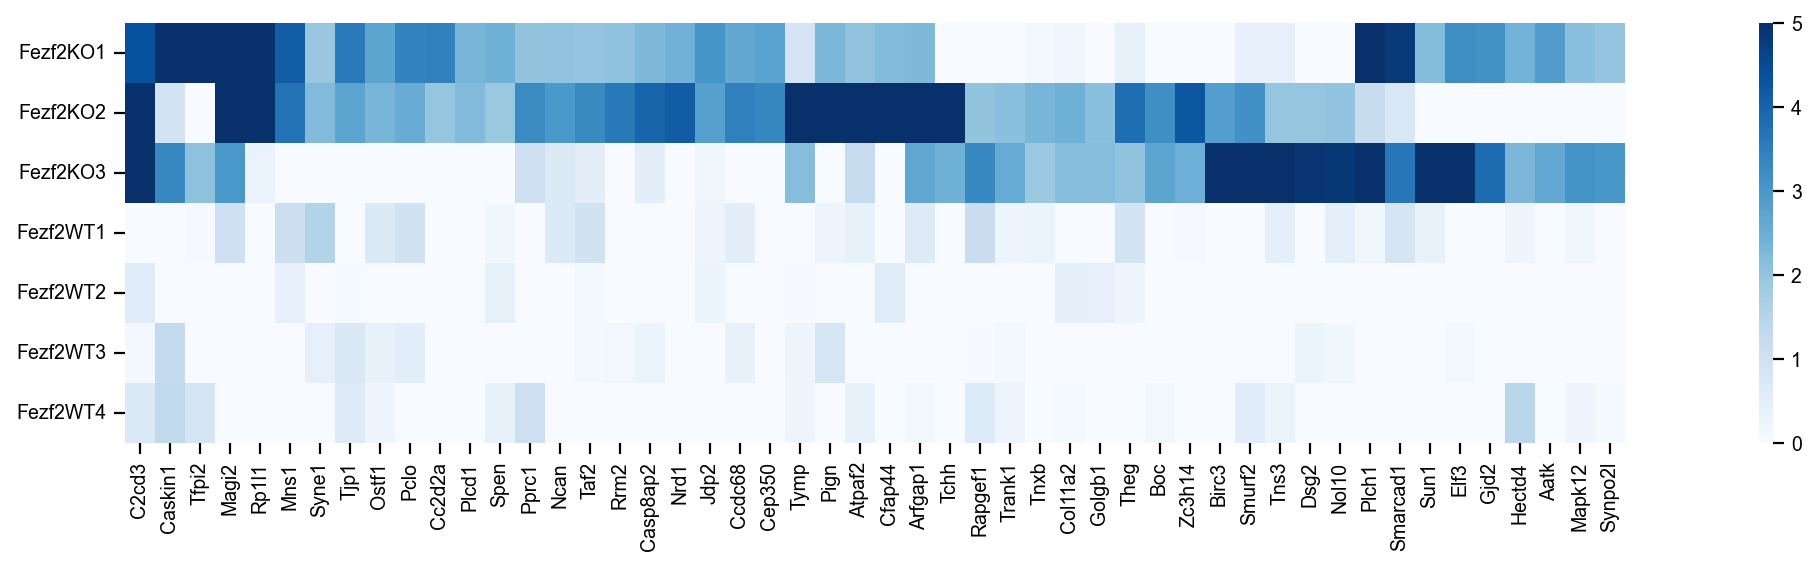

In [35]:
lfc_data_peptide = rna.tl.get_expression_matrix(averaged_adata, gene_data="LFC_background").copy()
lfc_data_peptide = lfc_data_peptide.loc[lfc_data_peptide.index.str.startswith("Fezf2"), filtered_hits_KO.index].T
LFC_heatmap(
    lfc_data_peptide.T,
    row_cluster=False,
    col_cluster=True,
    cmap="Blues",
    vmax=5,
    cell_width=5,
    cell_height=30,
    xticklabels=False,
    save_path="../analysis/B6_phip_seq/KO_peptides_heatmap.pdf"
)

top100 = filtered_hits_KO.sort_values(by="Fezf2KO_median", ascending=False).head(50).index.tolist()
lfc_data_peptide = rna.tl.get_expression_matrix(averaged_adata, gene_data="LFC_background").copy()
lfc_data_peptide = lfc_data_peptide.loc[lfc_data_peptide.index.str.startswith("Fezf2"), top100].T

lfc_data_peptide["gene"] = averaged_adata.var.gene
lfc_data_peptide = lfc_data_peptide.groupby("gene").mean()

LFC_heatmap(
    lfc_data_peptide.T,
    row_cluster=False,
    col_cluster=True,
    cmap="Blues",
    vmax=5,
    cell_width=15,
    cell_height=30,
    xticklabels=True,
    save_path="../analysis/B6_phip_seq/KO_top_50_peptide_genes.pdf"
)

## WT

In [36]:
filtered_hits_WT = averaged_adata.varm['hits'].copy()
filtered_hits_WT = filtered_hits_WT[filtered_hits_WT["Fezf2WT_median"] >= np.log2(3)]
filtered_hits_WT = filtered_hits_WT[filtered_hits_WT["Fezf2KO_max"] < np.log2(3)]
filtered_hits_WT = filtered_hits_WT[filtered_hits_WT["Background_max"] < np.log2(3)]

In [37]:
filtered_hits_WT.shape[0]

488

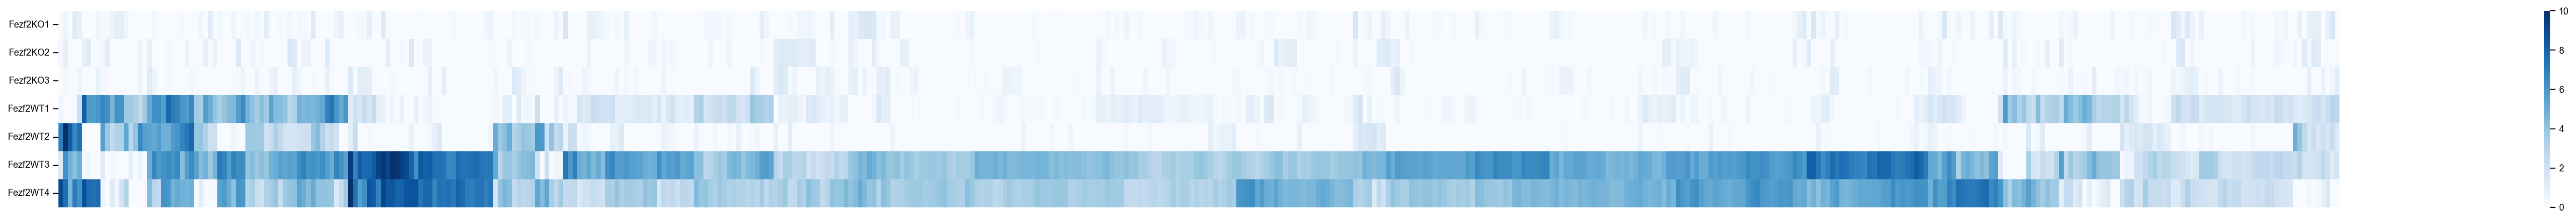

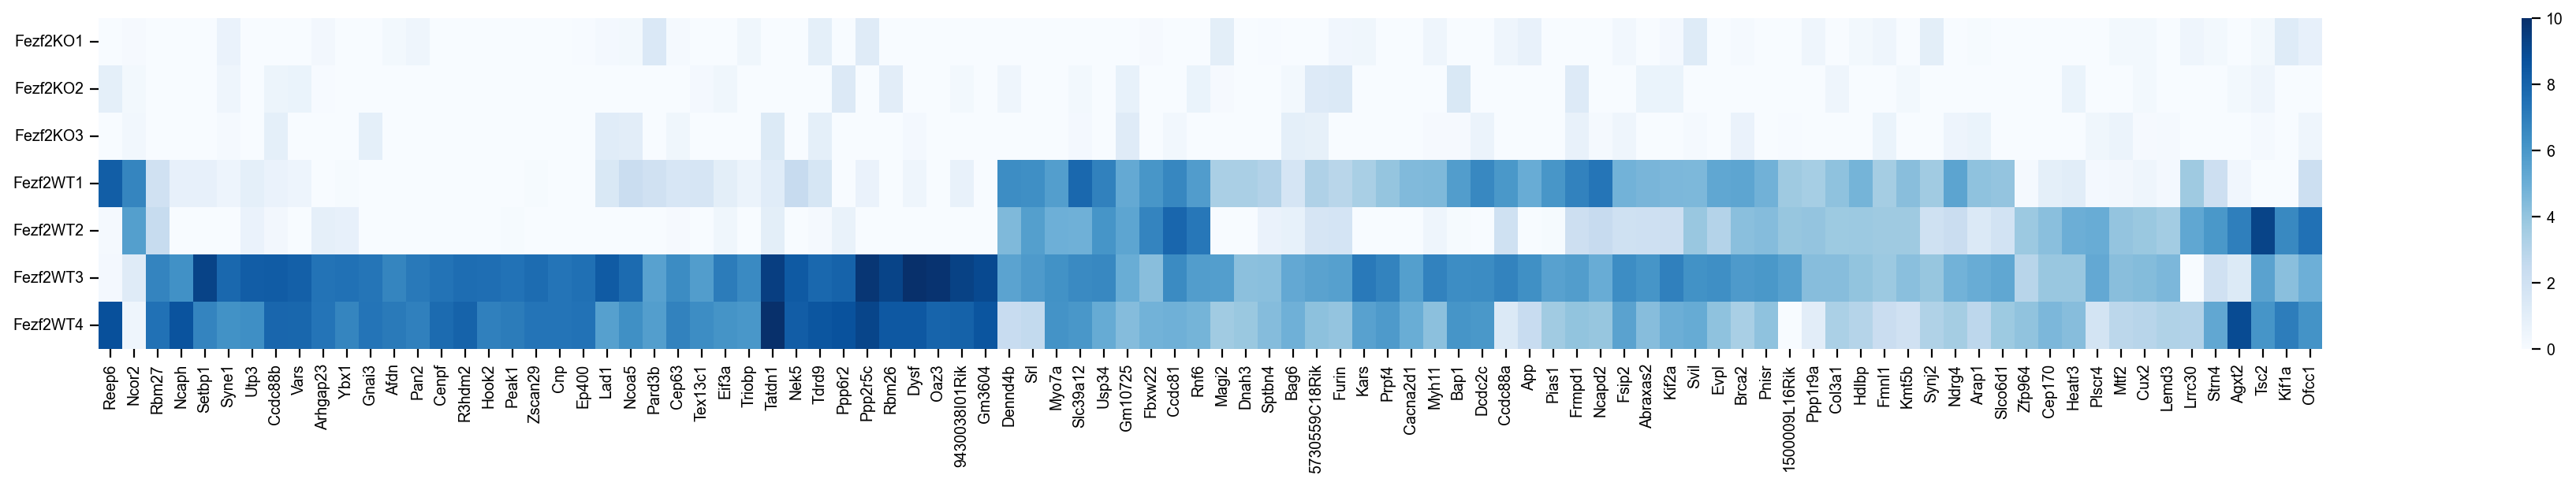

In [38]:
lfc_data_peptide = rna.tl.get_expression_matrix(averaged_adata, gene_data="LFC_background").copy()
lfc_data_peptide = lfc_data_peptide.loc[lfc_data_peptide.index.str.startswith("Fezf2"), filtered_hits_WT.index].T

LFC_heatmap(
    lfc_data_peptide.T,
    row_cluster=False,
    col_cluster=True,
    cmap="Blues",
    vmax=10,
    cell_width=5,
    cell_height=30,
    xticklabels=False
)

top100 = filtered_hits_WT.sort_values(by="Fezf2WT_median", ascending=False).head(100).index.tolist()

lfc_data_peptide = rna.tl.get_expression_matrix(averaged_adata, gene_data="LFC_background").copy()
lfc_data_peptide = lfc_data_peptide.loc[lfc_data_peptide.index.str.startswith("Fezf2"), top100].T

lfc_data_peptide["gene"] = averaged_adata.var.gene
lfc_data_peptide = lfc_data_peptide.groupby("gene").mean()

LFC_heatmap(
    lfc_data_peptide.T,
    row_cluster=False,
    col_cluster=True,
    cmap="Blues",
    vmax=10,
    cell_width=15,
    cell_height=30,
    xticklabels=True
)

## Sample correlation using hits

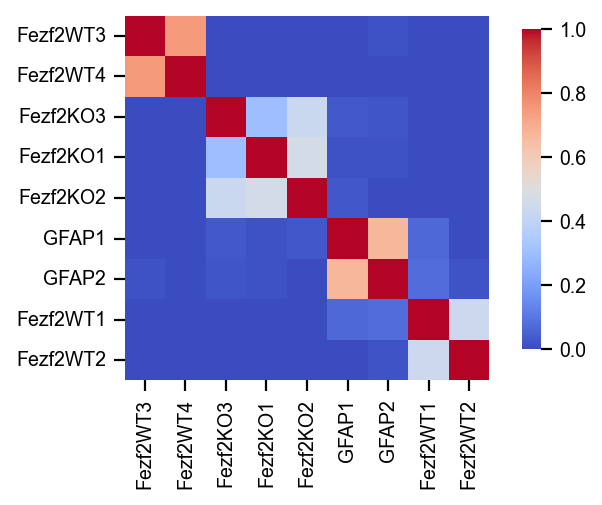

In [39]:
corr_plot(
    averaged_adata[
        averaged_adata.obs.GENOTYPE.isin(["Fezf2WT", "Fezf2KO", "GFAP"]),
        averaged_adata.var.index.isin(filtered_hits_WT.index.tolist() + filtered_hits_KO.index.tolist())
    ],
    layer="LFC_background",
    figsize=(4,4),
    cbar_args=[0.8, 0.3, 0.03, 0.5],
    vmin=0
)

# Aggregated isoform-level autoantibody load of hits

## KO

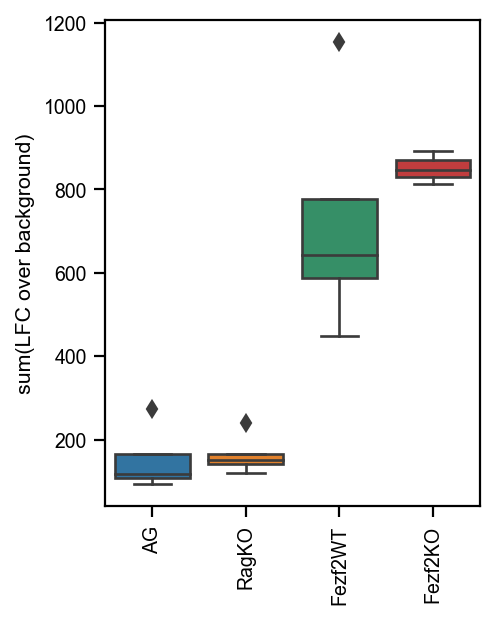

In [41]:
plot_FC_sum(
    averaged_adata[:, averaged_adata.var.gene_isoform.isin(filtered_hits_KO.gene_isoform)],
    "LFC_background",
    "GENOTYPE",
    ["AG", "RagKO", "Fezf2WT", "Fezf2KO"],
    order=["AG", "RagKO", "Fezf2WT", "Fezf2KO"],
    save_path="../analysis/B6_phip_seq/KO_peptide_sum_LFC.pdf"
)

## WT

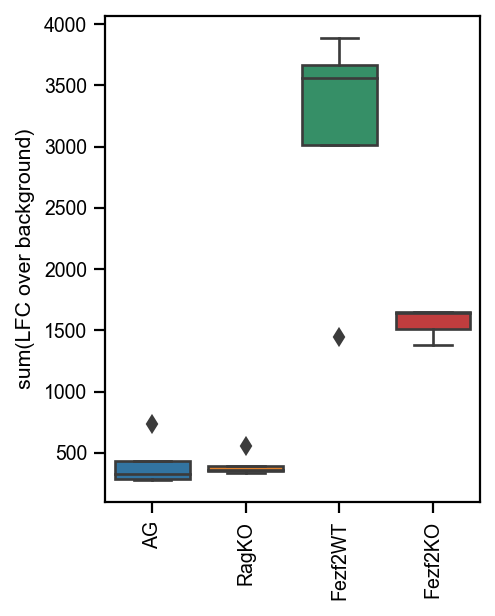

In [42]:
plot_FC_sum(
    averaged_adata[:, averaged_adata.var.gene_isoform.isin(filtered_hits_WT.gene_isoform)],
    "LFC_background",
    "GENOTYPE",
    ["AG", "RagKO", "Fezf2WT", "Fezf2KO"],
    order=["AG", "RagKO", "Fezf2WT", "Fezf2KO"]
)

# Hits of interest

In [43]:
filtered_hits_KO=filtered_hits_KO.sort_values(by="Fezf2KO_median", ascending=False)
filtered_hits_KO.head(15).gene

peptide
XP_011240130.1_PREDICTED:_C2_domain-containing_protein_3_isoform_X1_[Mus_musculus]_seq38                                                                                     C2cd3
NP_666358.2_retinitis_pigmentosa_1-like_1_protein_[Mus_musculus]_seq10                                                                                                       Rp1l1
XP_011238436.1_PREDICTED:_1-phosphatidylinositol_4_5-bisphosphate_phosphodiesterase_eta-1_isoform_X7_[Mus_musculus]_seq1                                                     Plch1
XP_006535812.1_PREDICTED:_membrane-associated_guanylate_kinase__WW_and_PDZ_domain-containing_protein_2_isoform_X7_[Mus_musculus]_seq5                                        Magi2
XP_006510887.2_PREDICTED:_meiosis-specific_nuclear_structural_protein_1_isoform_X2_[Mus_musculus]_seq4                                                                        Mns1
XP_011239507.1_PREDICTED:_SWI/SNF-related_matrix-associated_actin-dependent_regulator_of_chromati

In [44]:
fezf2_DE = pd.read_csv("../analysis/DE/Fezf2_DE_genes.csv", index_col=0)

In [45]:
filtered_hits_KO[filtered_hits_KO.gene.isin(fezf2_DE.index)]

neg_control,Background,COPA,Fezf2KO,Fezf2WT,GFAP,NFKB2HET,NODAIREKO,NODAIREWT,NODWT,gene,...,NODWT_median,Background_mean,COPA_mean,Fezf2KO_mean,Fezf2WT_mean,GFAP_mean,NFKB2HET_mean,NODAIREKO_mean,NODAIREWT_mean,NODWT_mean
peptide,,,,,,,,,,,,,,,,,,,,,
XP_017173424.1_PREDICTED:_coiled-coil_domain-containing_protein_68_isoform_X3_[Mus_musculus]_seq5,0,0,2,0,0,0,0,0,1,Ccdc68,...,0.0,0.030994,0.143572,2.037532,0.222420,0.237122,0.072850,0.480334,0.052952,0.526512
NP_034627.3_isocitrate_dehydrogenase_[NADP]_cytoplasmic_[Mus_musculus]_seq9,0,0,2,0,0,0,0,0,1,Idh1,...,0.0,0.118205,0.000000,1.600142,0.165825,0.027163,0.013493,0.103713,0.110790,0.260249
XP_011243982.1_PREDICTED:_keratin_Kb40_isoform_X2_[Mus_musculus]_seq1,0,0,2,0,0,0,0,0,0,Krt78,...,0.0,0.000000,0.000000,1.261284,0.000000,0.000000,0.000000,0.000000,0.000000,0.118233
NP_899006.1_G_protein-regulated_inducer_of_neurite_outgrowth_3_[Mus_musculus]_seq16,0,0,2,0,0,0,3,0,0,Gprin3,...,0.0,0.109492,0.123199,1.624567,0.194955,0.560832,0.000000,0.672224,0.041812,0.031283
XP_006507297.1_PREDICTED:_amyloid_beta_A4_precursor_protein-binding_family_B_member_1_isoform_X5_[Mus_musculus]_seq1,0,1,2,0,0,0,0,0,0,Apbb1,...,0.0,0.000000,0.683598,1.397231,0.237612,0.000000,0.079044,0.191955,0.291293,0.047739


In [161]:
filtered_hits_KO[filtered_hits_KO.gene.isin(["Sgsh"])]

neg_control,Background,COPA,Fezf2KO,Fezf2WT,GFAP,NFKB2HET,NODAIREKO,NODAIREWT,NODWT,gene,...,NODWT_median,Background_mean,COPA_mean,Fezf2KO_mean,Fezf2WT_mean,GFAP_mean,NFKB2HET_mean,NODAIREKO_mean,NODAIREWT_mean,NODWT_mean
peptide,,,,,,,,,,,,,,,,,,,,,
NP_061292.2_N-sulphoglucosamine_sulphohydrolase_precursor_[Mus_musculus]_seq11,0,0,2,0,0,0,0,1,0,Sgsh,...,0.0,0.0,0.079995,2.379806,0.063645,0.0,0.020408,0.04289,0.286684,0.114866


# Gene-level autoantibody load

In [ ]:
Plch1 Sun1 Tns3 Sgsh Adrm1 Arfgap1 Atp2b3 Atpaf2 Smarcad1 Elf3 Gjd2

In [ ]:
Atpaf2 Adrm1

In [166]:
gene = "Sgsh"
isoform = ""

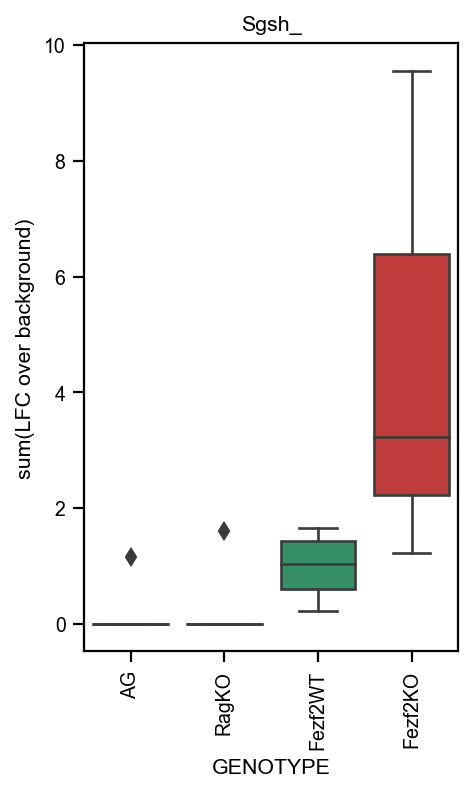

In [167]:
gene_LFC_sum_plot(
    averaged_adata,
    gene=gene,
    isoform_subset=isoform,
    LFC_layer="LFC_background",
    obs_grouping_key="GENOTYPE",
    include_groups=["AG", "RagKO", "Fezf2WT", "Fezf2KO"],
    order=["AG", "RagKO", "Fezf2WT", "Fezf2KO"]
)

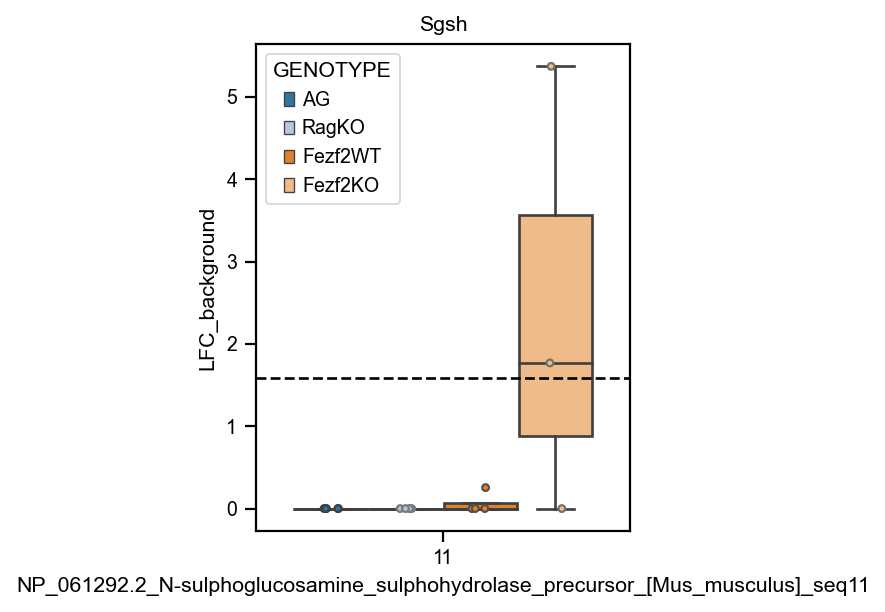

In [168]:
for peptide in filtered_hits_KO[filtered_hits_KO.gene == gene].index:
    peptide_level_box_plot(
        averaged_adata,
        "GENOTYPE",
        layer="LFC_background",
        peptide=peptide,
        threshold=np.log2(3),
        figsize=(3,4),
        palette="tab20",
        hue_order=["AG", "RagKO", "Fezf2WT", "Fezf2KO"]
    )

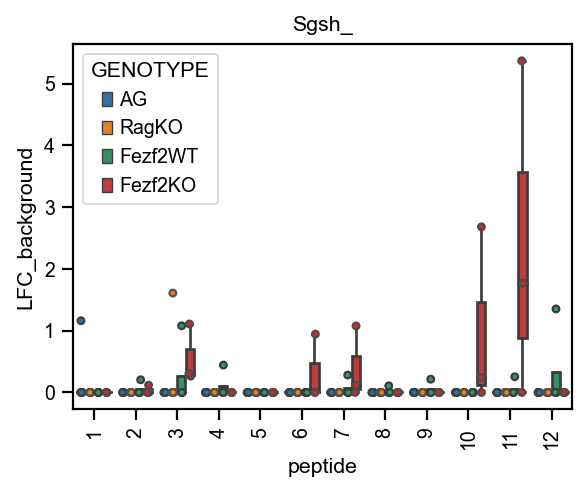

In [171]:
gene_level_box_plot(
    averaged_adata,
    "GENOTYPE",
    layer="LFC_background",
    gene=gene,
    isoform_subset = isoform,
    figsize=(4,3),
    hue_order=["AG", "RagKO", "Fezf2WT", "Fezf2KO"],
    save_path="../analysis/B6_phip_seq/Sgsh_gene_boxplot.pdf"
)

In [153]:
9*0.4

3.6

In [131]:
gene = "Elf3"
isoform = "isoform_1"

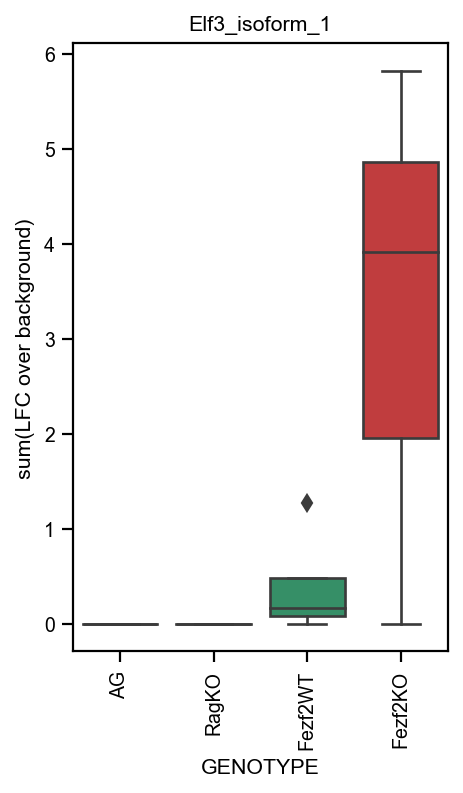

In [132]:
gene_LFC_sum_plot(
    averaged_adata,
    gene=gene,
    isoform_subset=isoform,
    LFC_layer="LFC_background",
    obs_grouping_key="GENOTYPE",
    include_groups=["AG", "RagKO", "Fezf2WT", "Fezf2KO"],
    order=["AG", "RagKO", "Fezf2WT", "Fezf2KO"]
)

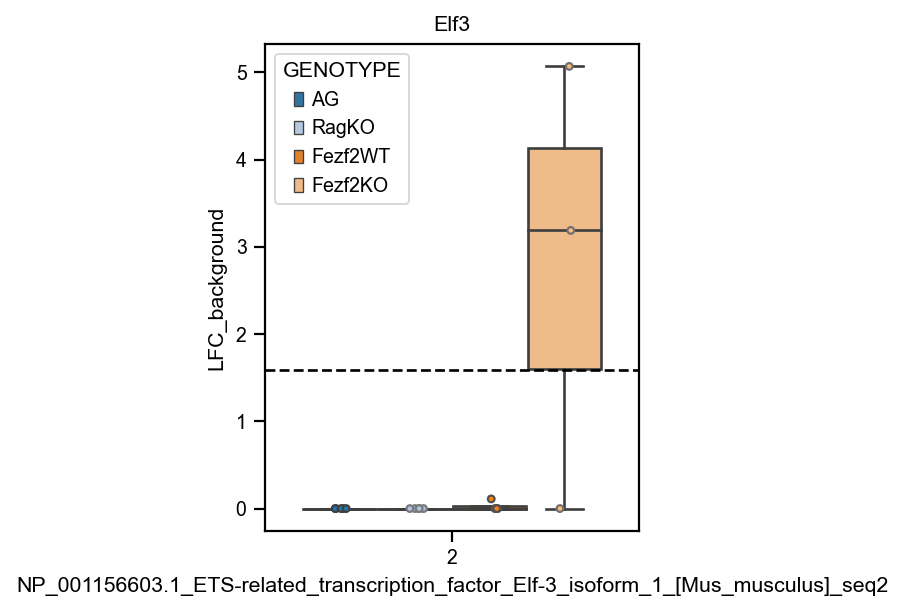

In [133]:
for peptide in filtered_hits_KO[filtered_hits_KO.gene == gene].index:
    peptide_level_box_plot(
        averaged_adata,
        "GENOTYPE",
        layer="LFC_background",
        peptide=peptide,
        threshold=np.log2(3),
        figsize=(3,4),
        palette="tab20",
        hue_order=["AG", "RagKO", "Fezf2WT", "Fezf2KO"]
    )

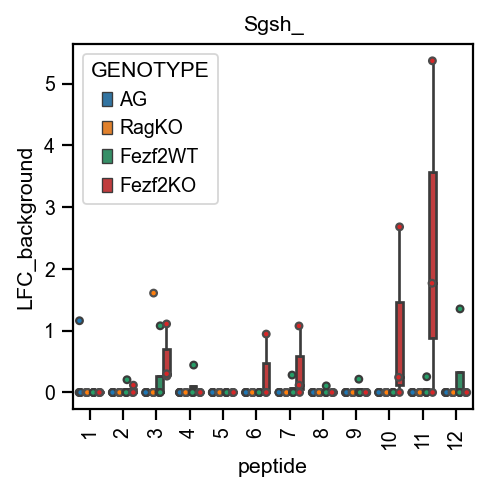

In [172]:
gene_level_box_plot(
    averaged_adata,
    "GENOTYPE",
    layer="LFC_background",
    gene=gene,
    isoform_subset = isoform,
    figsize=(3.2,3),
    hue_order=["AG", "RagKO", "Fezf2WT", "Fezf2KO"],
    save_path="../analysis/B6_phip_seq/Elf3_isoform_1_gene_boxplot.pdf"
)

In [128]:
gene = "Sun1"
isoform = "isoform_2"

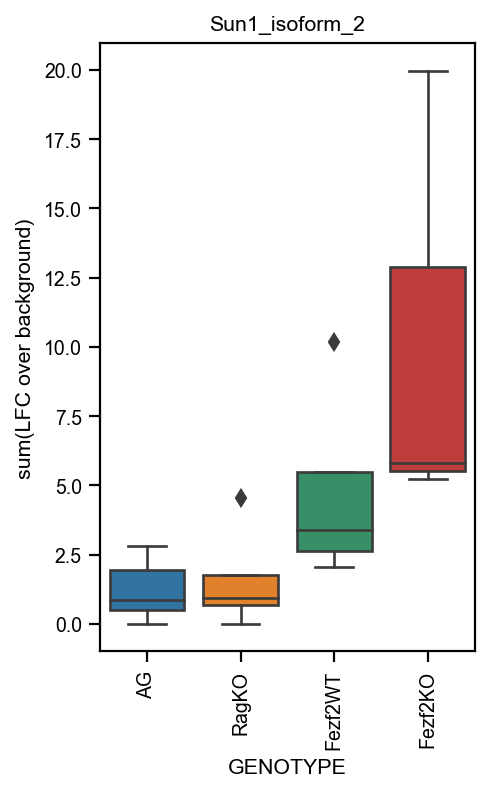

In [75]:
gene_LFC_sum_plot(
    averaged_adata,
    gene=gene,
    isoform_subset=isoform,
    LFC_layer="LFC_background",
    obs_grouping_key="GENOTYPE",
    include_groups=["AG", "RagKO", "Fezf2WT", "Fezf2KO"],
    order=["AG", "RagKO", "Fezf2WT", "Fezf2KO"]
)

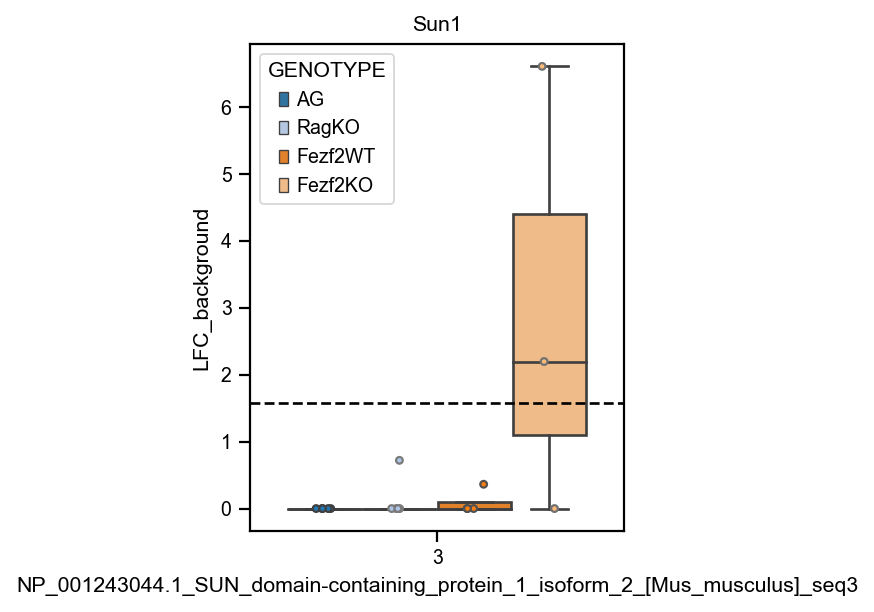

In [76]:
for peptide in filtered_hits_KO[filtered_hits_KO.gene == gene].index:
    peptide_level_box_plot(
        averaged_adata,
        "GENOTYPE",
        layer="LFC_background",
        peptide=peptide,
        threshold=np.log2(3),
        figsize=(3,4),
        palette="tab20",
        hue_order=["AG", "RagKO", "Fezf2WT", "Fezf2KO"]
    )

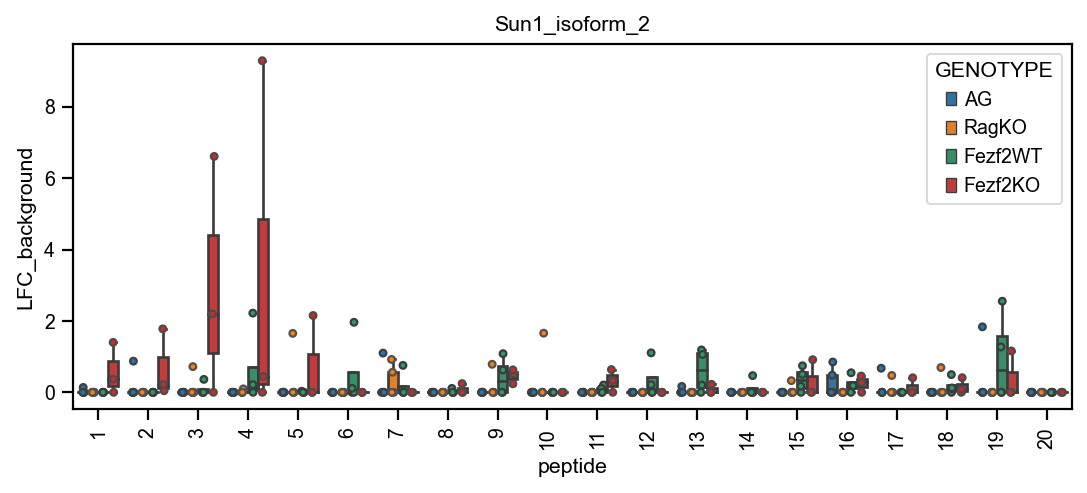

In [77]:
gene_level_box_plot(
    averaged_adata,
    "GENOTYPE",
    layer="LFC_background",
    gene=gene,
    isoform_subset = isoform,
    figsize=(8,3),
    hue_order=["AG", "RagKO", "Fezf2WT", "Fezf2KO"],
    save_path="../analysis/B6_phip_seq/Sun1_isoform2_gene_boxplot.pdf"
)

In [174]:
filtered_hits_KO.to_csv("../analysis/B6_phip_seq/KO_peptides.csv")

# Hit expression in cell x gene atlas

In [176]:
tissue_expression = np.load(f"{processedDataPath}/cell_x_gene_atlas/expression/cell_x_gene_atlas_tissue_general_expression.npy")
genes = pd.read_csv(f"{processedDataPath}/cell_x_gene_atlas/expression/keep_genes.csv").feature_name
index = pd.read_csv(f"{processedDataPath}/cell_x_gene_atlas/expression/tissue_general_index.csv").tissue_general
tissue_expression = pd.DataFrame(tissue_expression, index=index, columns=genes)

## KO

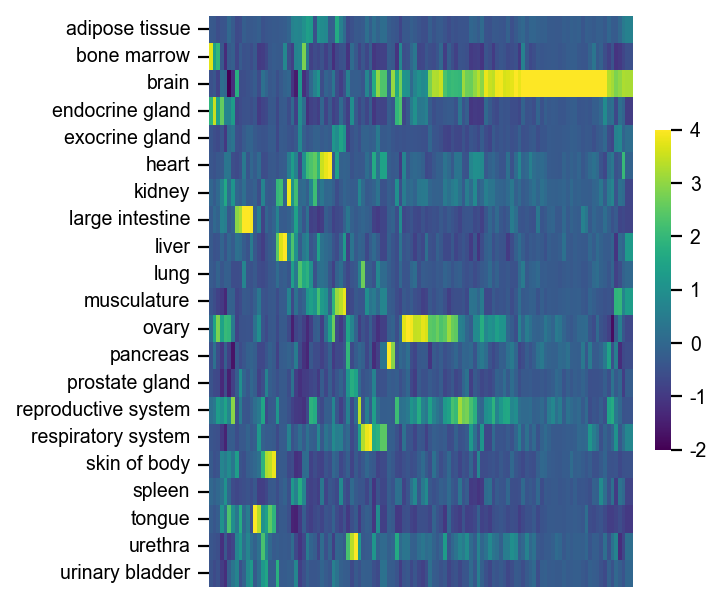

In [177]:
genes = [i for i in filtered_hits_KO.gene if i in tissue_expression]
cg = sns.clustermap(
    tissue_expression[genes],
    z_score=1,
    cmap="viridis",
    row_cluster=False,
    xticklabels=False,
    yticklabels=True,
    figsize=(5,5),
    vmin=-2,
    vmax=4
)
cg.ax_cbar.set_position([0.72,0.25,0.02,0.4])
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_heatmap.yaxis.tick_left()
cg.ax_heatmap.set_ylabel("")
cg.ax_heatmap.set_xlabel("")
plt.show()

## WT

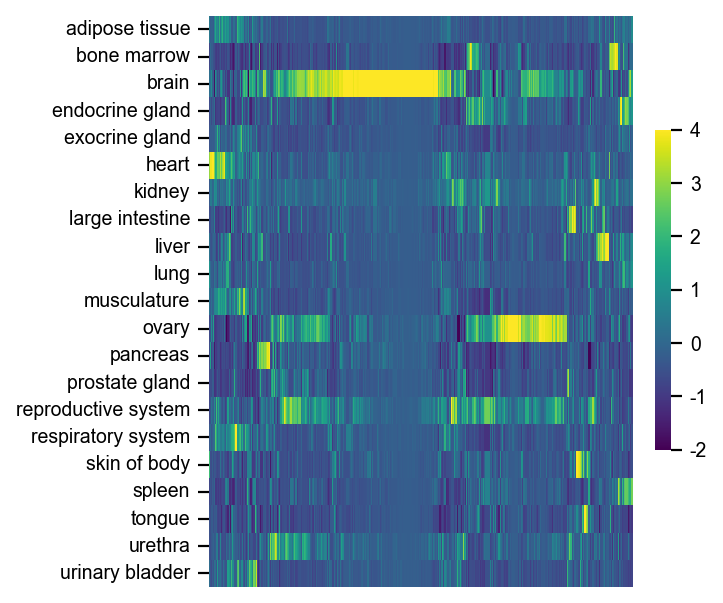

In [178]:
genes = [i for i in filtered_hits_WT.gene if i in tissue_expression]
cg = sns.clustermap(
    tissue_expression[genes],
    row_cluster=False,
    z_score=1,
    cmap="viridis",
    xticklabels=False,
    yticklabels=True,
    figsize=(5,5),
    vmin=-2,
    vmax=4
)
cg.ax_cbar.set_position([0.72,0.25,0.02,0.4])
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
cg.ax_heatmap.yaxis.tick_left()
cg.ax_heatmap.set_ylabel("")
cg.ax_heatmap.set_xlabel("")
plt.show()